In [1]:
import os
import copy
import time
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import timm

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torchsummary import summary

from nltk import ngrams
from nltk.translate.bleu_score import corpus_bleu
from collections import Counter

from ipynb.fs.defs.transfer_learning import Vocabulary, TextPreprocessor, \
Flickr8kDataset, PadCollate, DataPrep, ModelSaver, EarlyStoppingValidator, ModelTrainerTester, \
CNNEncoder, RNNDecoder, EncoderDecoder, bleu_n

In [2]:
# Preset batch size, number of epochs, learning rate, random state, device
batch_size = 128
epochs = 300
lr = 1e-4
random_state = 21
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Presets for image transformation: image resolution and mean/std for normalising
img_height, img_width = 224, 224  # Min resolution for all models

mean_imgnet = [0.485, 0.456, 0.406]  # Value taken from ImageNet
std_imgnet = [0.229, 0.224, 0.225]  # Value taken from ImageNet

# Transforms
transform = transforms.Compose(
    [
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_imgnet, std=std_imgnet)
    ]
)

In [4]:
# Root paths for texts and images
data_text_path = "./Flickr8k_text"
data_img_path = "./Flicker8k_Dataset"

# Train-validation-test image names
imgs_train = "Flickr_8k.trainImages.txt"
imgs_val = "Flickr_8k.devImages.txt"
imgs_test = "Flickr_8k.testImages.txt"


token_captions_path = f"{data_text_path}/Flickr8k.token.txt"
imgs_train_path = f"{data_text_path}/{imgs_train}"
imgs_val_path = f"{data_text_path}/{imgs_val}"
imgs_test_path = f"{data_text_path}/{imgs_test}"

In [5]:
# Generate the dataframes
df = pd.read_csv(token_captions_path, delimiter="\t", names=["image", "caption"])
df_train = pd.read_csv(imgs_train_path, names=["image"])
df_val = pd.read_csv(imgs_val_path, names=["image"])
df_test = pd.read_csv(imgs_test_path, names=["image"])

In [6]:
# Get img name excluding the caption number
df["image"] = df["image"].str.extract(r"^(.*)[#?]")

In [7]:
# Now we can reload the train, validation and test sets
df_train = df[df["image"].isin(df_train["image"])]
df_val = df[df["image"].isin(df_val["image"])]
df_test = df[df["image"].isin(df_test["image"])]

In [8]:
# Generate training and testing samples: 40% of whole dataset
df_train_sample = df_train.groupby('image', group_keys=False).apply(
    lambda s: s.sample(frac=0.4, random_state=random_state)
)
df_val_sample = df_val.groupby('image', group_keys=False).apply(
    lambda s: s.sample(frac=0.4, random_state=random_state)
)

In [9]:
# Get the other 60% of the dataset to continue training
df_train_sample_rest = df_train[~(df_train["caption"].isin(df_train_sample["caption"]))]
df_val_sample_rest = df_val[~(df_val["caption"].isin(df_val_sample["caption"]))]

In [10]:
# Build a vocabulary where all words need to appear at least
# twice in the corpus
vocab_full = Vocabulary(df["caption"], freq_threshold=2)
vocab_full.build_vocab()
# Store the vocab size in a variable for later use
vocab_size = len(vocab_full)

# Fine-tuning models

## Fine-tuning 1: Resume training on the last linear layer and the RNN cell

In [11]:
# Parameters of Model 3
embed_size = 256
hidden_size = 256
num_layers = 1
nasnet3_1 = timm.create_model('nasnetalarge', pretrained=True)

# Load model
torch.random.manual_seed(random_state)
cnn_gru1_1 = EncoderDecoder(model_id='fine-tuning-1', cnn=nasnet3_1, rnn=nn.GRU, embed_size=embed_size, 
                           hidden_size=hidden_size, vocab_size=vocab_size, 
                           num_layers=num_layers)
# Reload weights of learned head
cnn_gru1_1.load_state_dict(
    torch.load(
        f"./checkpoints-transfer-learning/NASNetALarge-GRU-transfer-learning-3_EP80.pt"
    )
)

# Turn off all parameter updates
# for name, param in cnn_gru1_1.named_parameters():
#     if name.startswith("encoder.model.conv0"):
#         param.requires_grad = True
#     if not name.startswith("encoder.model.conv0"):
#         param.requires_grad = False
    

<All keys matched successfully>

In [12]:
# Initiate the transfer learning trainer with the full datasets and 
# preset hyperparameters
cnn_gru1_1_trainer = ModelTrainerTester(model=cnn_gru1_1, device=device, lr=lr, 
                                        batch_size=batch_size, vocab=vocab_full, 
                                        transform=transform, df_train=df_train_sample_rest, 
                                        df_val=df_val_sample_rest, df_test=df_test, 
                                        n_epochs=epochs, 
                                        checkpoints_path="./checkpoints-fine-tuning")

In [13]:
cnn_gru1_1_trainer.train_eval()

EPOCH [1/300],	 Train Loss: 2.925, Val Loss: 3.042, Elapsed time: 4m 22s
EPOCH [10/300],	 Train Loss: 2.698, Val Loss: 2.967, Elapsed time: 45m 8s
EPOCH [20/300],	 Train Loss: 2.543, Val Loss: 2.930, Elapsed time: 91m 15s
EPOCH [30/300],	 Train Loss: 2.418, Val Loss: 2.913, Elapsed time: 137m 44s
EPOCH [40/300],	 Train Loss: 2.320, Val Loss: 2.908, Elapsed time: 184m 3s
EPOCH [50/300],	 Train Loss: 2.286, Val Loss: 2.902, Elapsed time: 229m 56s
Training completed in 258m 5s for NASNetALarge-GRU-fine-tuning-1.
Total epochs trained: 56
Best epoch: 45
Best val loss: 2.8997570673624673


## Fine-tuning 2: Unfreezing the first convolutional layer 

In [15]:
nasnet3_2 = timm.create_model('nasnetalarge', pretrained=True)

# Load model
torch.random.manual_seed(random_state)
cnn_gru1_2 = EncoderDecoder(model_id='fine-tuning-2', cnn=nasnet3_2, rnn=nn.GRU, embed_size=embed_size, 
                           hidden_size=hidden_size, vocab_size=vocab_size, 
                           num_layers=num_layers)
# Reload weights of learned head
cnn_gru1_2.load_state_dict(
    torch.load(
        f"./checkpoints-fine-tuning/NASNetALarge-GRU-fine-tuning-1_EP45.pt"
    )
)

<All keys matched successfully>

In [17]:
# Turn off all parameter updates
for name, param in cnn_gru1_2.named_parameters():
    if name.startswith("encoder.model.conv0"):
        param.requires_grad = True
    if not name.startswith("encoder.model.conv0"):
        param.requires_grad = False

In [18]:
# Initiate the transfer learning trainer with the full datasets and 
# preset hyperparameters
cnn_gru1_2_trainer = ModelTrainerTester(model=cnn_gru1_2, device=device, lr=lr, 
                                        batch_size=32, vocab=vocab_full, 
                                        transform=transform, df_train=df_train, 
                                        df_val=df_val, df_test=df_test, 
                                        n_epochs=epochs, 
                                        checkpoints_path="./checkpoints-fine-tuning")

In [19]:
cnn_gru1_2_trainer.train_eval()

EPOCH [1/300],	 Train Loss: 2.399, Val Loss: 2.961, Elapsed time: 17m 35s
EPOCH [10/300],	 Train Loss: 2.397, Val Loss: 2.962, Elapsed time: 180m 2s
Training completed in 309m 33s for NASNetALarge-GRU-fine-tuning-2.
Total epochs trained: 17
Best epoch: 6
Best val loss: 2.959515399993605


## Fine-tuning 3: Unfreezing the first and second layers

In [20]:
nasnet3_3 = timm.create_model('nasnetalarge', pretrained=True)

# Load model
torch.random.manual_seed(random_state)
cnn_gru1_3 = EncoderDecoder(model_id='fine-tuning-3', cnn=nasnet3_3, rnn=nn.GRU, embed_size=embed_size, 
                           hidden_size=hidden_size, vocab_size=vocab_size, 
                           num_layers=num_layers)
# Reload weights of learned head
cnn_gru1_3.load_state_dict(
    torch.load(
        f"./checkpoints-fine-tuning/NASNetALarge-GRU-fine-tuning-1_EP45.pt"
    )
)

<All keys matched successfully>

In [29]:
for name, param in cnn_gru1_3.named_parameters():
    if name.startswith("encoder.model.cell_stem_0") or name.startswith("encoder.model.conv0"):
        param.requires_grad = True
    elif not name.startswith("encoder.model.cell_stem_0") or not name.startswith("encoder.model.conv0"):
        param.requires_grad = False

In [32]:
# Initiate the transfer learning trainer with the full datasets and 
# preset hyperparameters
cnn_gru1_3_trainer = ModelTrainerTester(model=cnn_gru1_3, device=device, lr=lr, 
                                        batch_size=32, vocab=vocab_full, 
                                        transform=transform, df_train=df_train, 
                                        df_val=df_val, df_test=df_test, 
                                        n_epochs=epochs, 
                                        checkpoints_path="./checkpoints-fine-tuning")

In [33]:
cnn_gru1_3_trainer.train_eval()

EPOCH [1/300],	 Train Loss: 2.398, Val Loss: 2.961, Elapsed time: 18m 1s
EPOCH [10/300],	 Train Loss: 2.392, Val Loss: 2.962, Elapsed time: 186m 33s
Training completed in 337m 34s for NASNetALarge-GRU-fine-tuning-3.
Total epochs trained: 18
Best epoch: 6
Best val loss: 2.959603535901209


# Winning model: Fine-tuning 1

The model from fine-tuning 1 will get to generate all captions for the test dataset now.

## Function to generate test captions

In [45]:
from PIL import Image

def generate_test_caps(trainer, data_img_path="./Flicker8k_Dataset"):
    """
    Runs the model on the testing set, and generates the predicted captions
    for all examples in the test set.

    Params:
        data_img_path: str
            The relative path to the full RGB image data.
    """
    # Load best model's weights for testing
    best_model = copy.deepcopy(trainer.model)
    best_model.load_state_dict(torch.load(f"{trainer.model_saver.checkpoints_path}/NASNetALarge-GRU-fine-tuning-1_EP45.pt"))
    # Send the model to the specified device
    best_model.to(device)
    # Set model to evaluation mode
    best_model.eval()
    # Initialise an empty list that will store lists caption tokens
    all_caps = []
    for img_name in df_test["image"].unique():
        img_full = Image.open(f"{data_img_path}/{img_name}")
        img_full = img_full.convert("RGB") if img_full.mode != 'RGB' else img_full
        img_transform = transform(img_full)
        img_input = img_transform.to(device)
        # Get predicted caption as a list of tokens
        pred_cap = best_model.generate_caption(img_input, vocab_full)
        # Append to the outer list of list of predictions of type list[list[str]]
        all_caps.append(pred_cap)

    return all_caps

## Generate all test captions

In [46]:
all_test_caps = generate_test_caps(cnn_gru1_1_trainer)

In [51]:
# Check the first 10 captions generated by the model
for i in range(10):
    print(" ".join(all_test_caps[i]))

a woman in a white shirt and a brown jacket is standing in front of a large building
a boy in a blue shirt and blue shorts is running through the water
a man in a red shirt is standing on a rock with a blue and white shirt
a white dog is jumping over a hurdle
a little girl in a pink shirt and blue jeans is sitting on a wooden bench
a black dog is running through the water
a brown and white dog is running through the grass
a little boy is playing with a blue toy
a brown and white dog is running through the grass
a boy in a blue shirt is holding a baby in a red shirt


## Generate the list of lists for the reference (ground truth) captions

In [52]:
# Initialise a text preprocessor object defined in the last notebook
text_prep = TextPreprocessor(df_test["caption"])

In [53]:
# Preprocess all texts into a Pandas series of lists
all_reference_caps = text_prep.preprocess_text()

In [61]:
# Reset the index for iterating through the Pandas series
all_reference_caps.reset_index(drop=True, inplace=True)

In [62]:
# Create a list of lists with the same length as the list of hypotheses
grouped_reference_caps = []
for i in range(0, len(all_reference_caps), 5):
    grouped_reference_caps.append([all_reference_caps.iloc[j] for j in range(i, i+5)])

In [66]:
# Sanity check: length of references list
len(grouped_reference_caps)

1000

In [68]:
# Sanity check: length of hypotheses list
len(all_test_caps)

1000

# Quantitative Assessment: BLEU-1 to BLEU-4 scores

Now that we have the grouped reference captions and their predicted hypotheses, it's time to generate the corpus BLEU-1 to BLEU-4 scores for the best model.

In [69]:
corpus_bleu_4 = bleu_n(str_ref=grouped_reference_caps,
                       str_pred=all_test_caps)

In [70]:
# These are the BLEU-1 to BLEU-4 scores
corpus_bleu_4

[0.5064649485442871,
 0.3252636160996704,
 0.2015449464796814,
 0.12978067910979993]

# Qualitative Assessment: Generated Captions versus Their Images

In [72]:
# Get all image names
all_image_names = df_test['image'].unique()

In [79]:
from textwrap import wrap

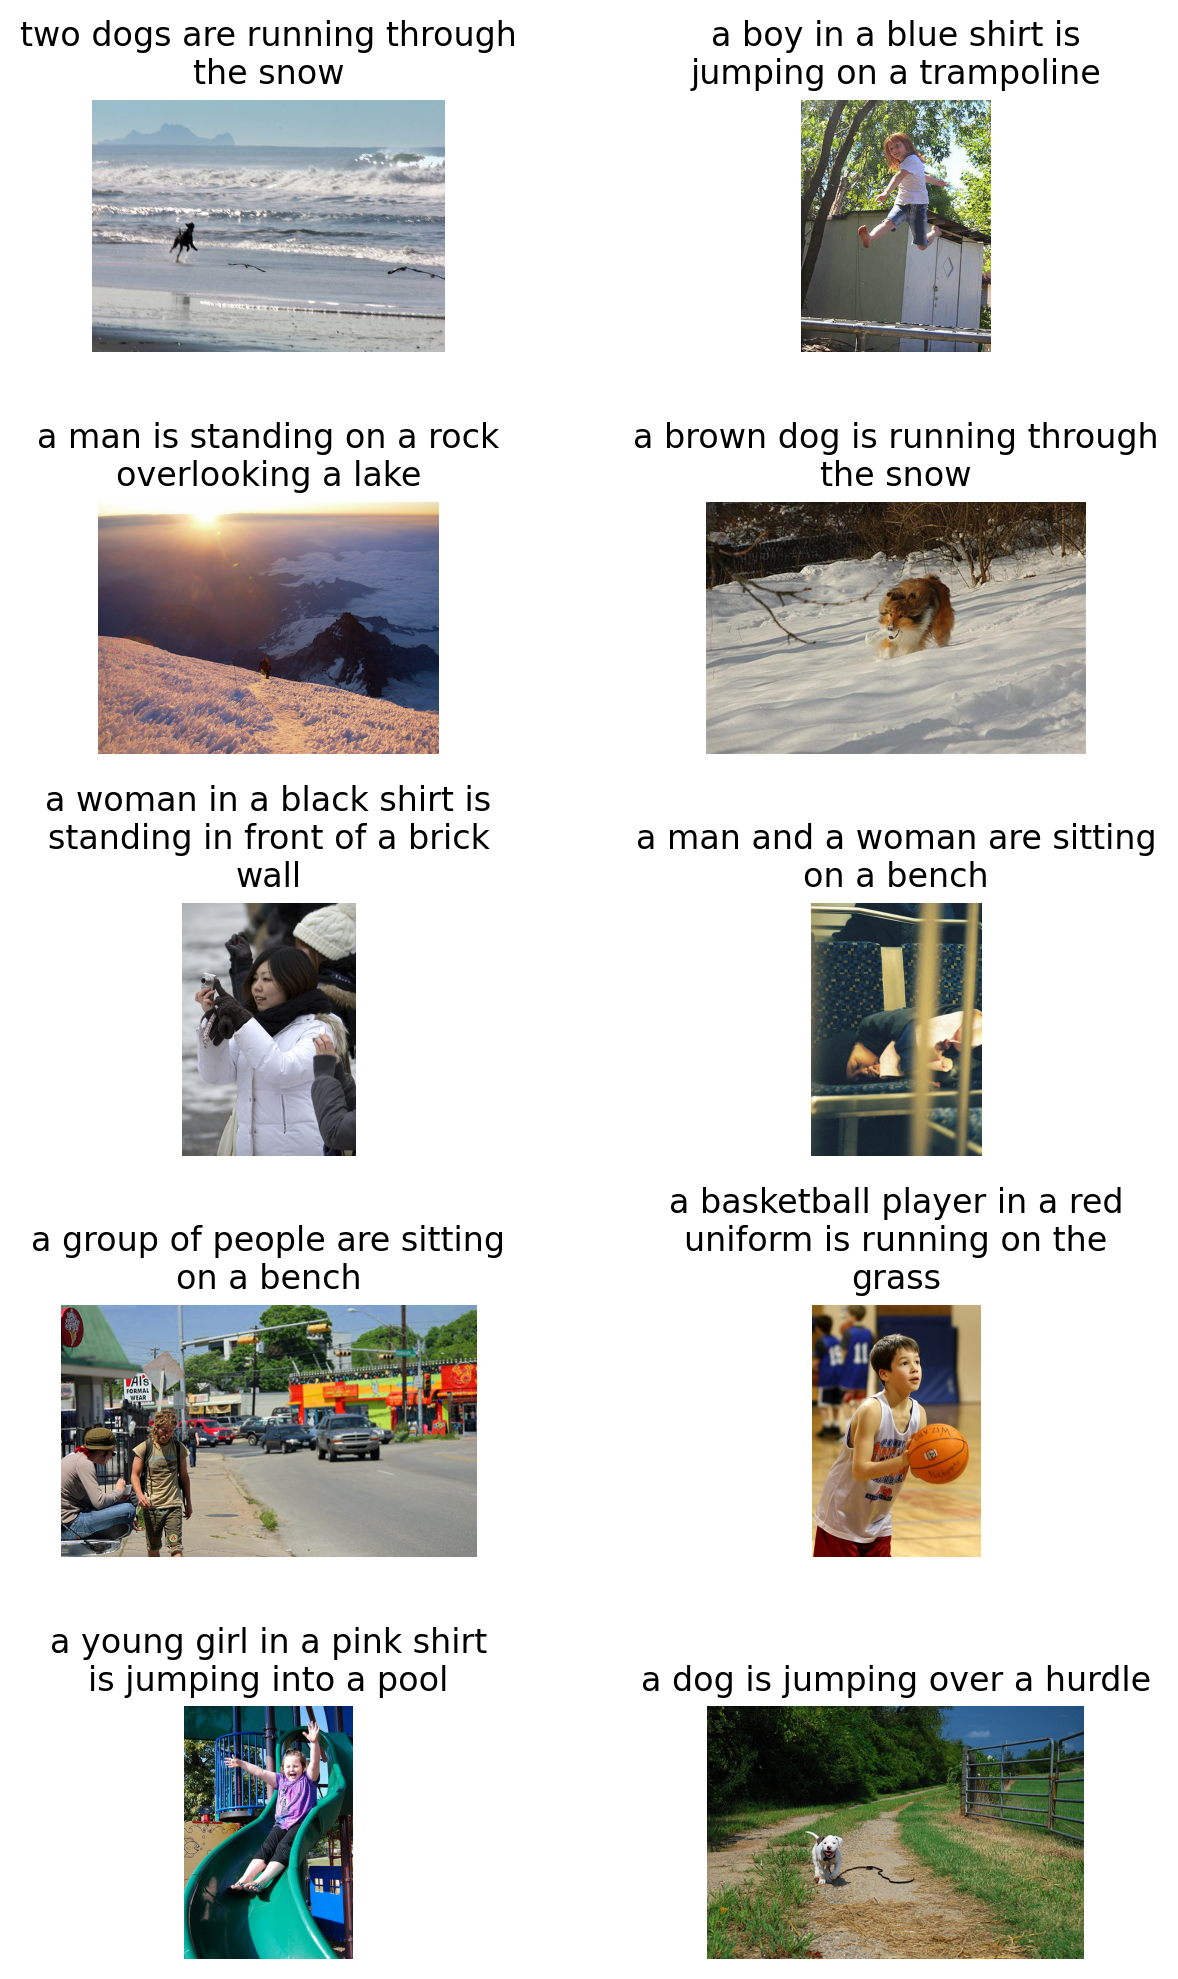

In [91]:
plt.figure(figsize=(7, 10), dpi=200)

nrows, ncols = 5, 2


for i in range(nrows*ncols):
    # Set running seed for reproducible image generation
    np.random.seed(i)
    # Get a random index
    random_idx = np.random.randint(0, len(all_image_names))
    # Get the image
    img_full = Image.open(f"./Flicker8k_Dataset/{all_image_names[random_idx]}")
    img_full = img_full.convert("RGB") if img_full.mode != 'RGB' else img_full
    # Get the caption for that image
    label = "\n".join(wrap((" ".join(all_test_caps[random_idx])), 30))
    # Draw a subplot
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(img_full)
    ax.set_title(label)
    plt.axis("off")
    
plt.tight_layout()
plt.savefig("pred1.png")
plt.show()

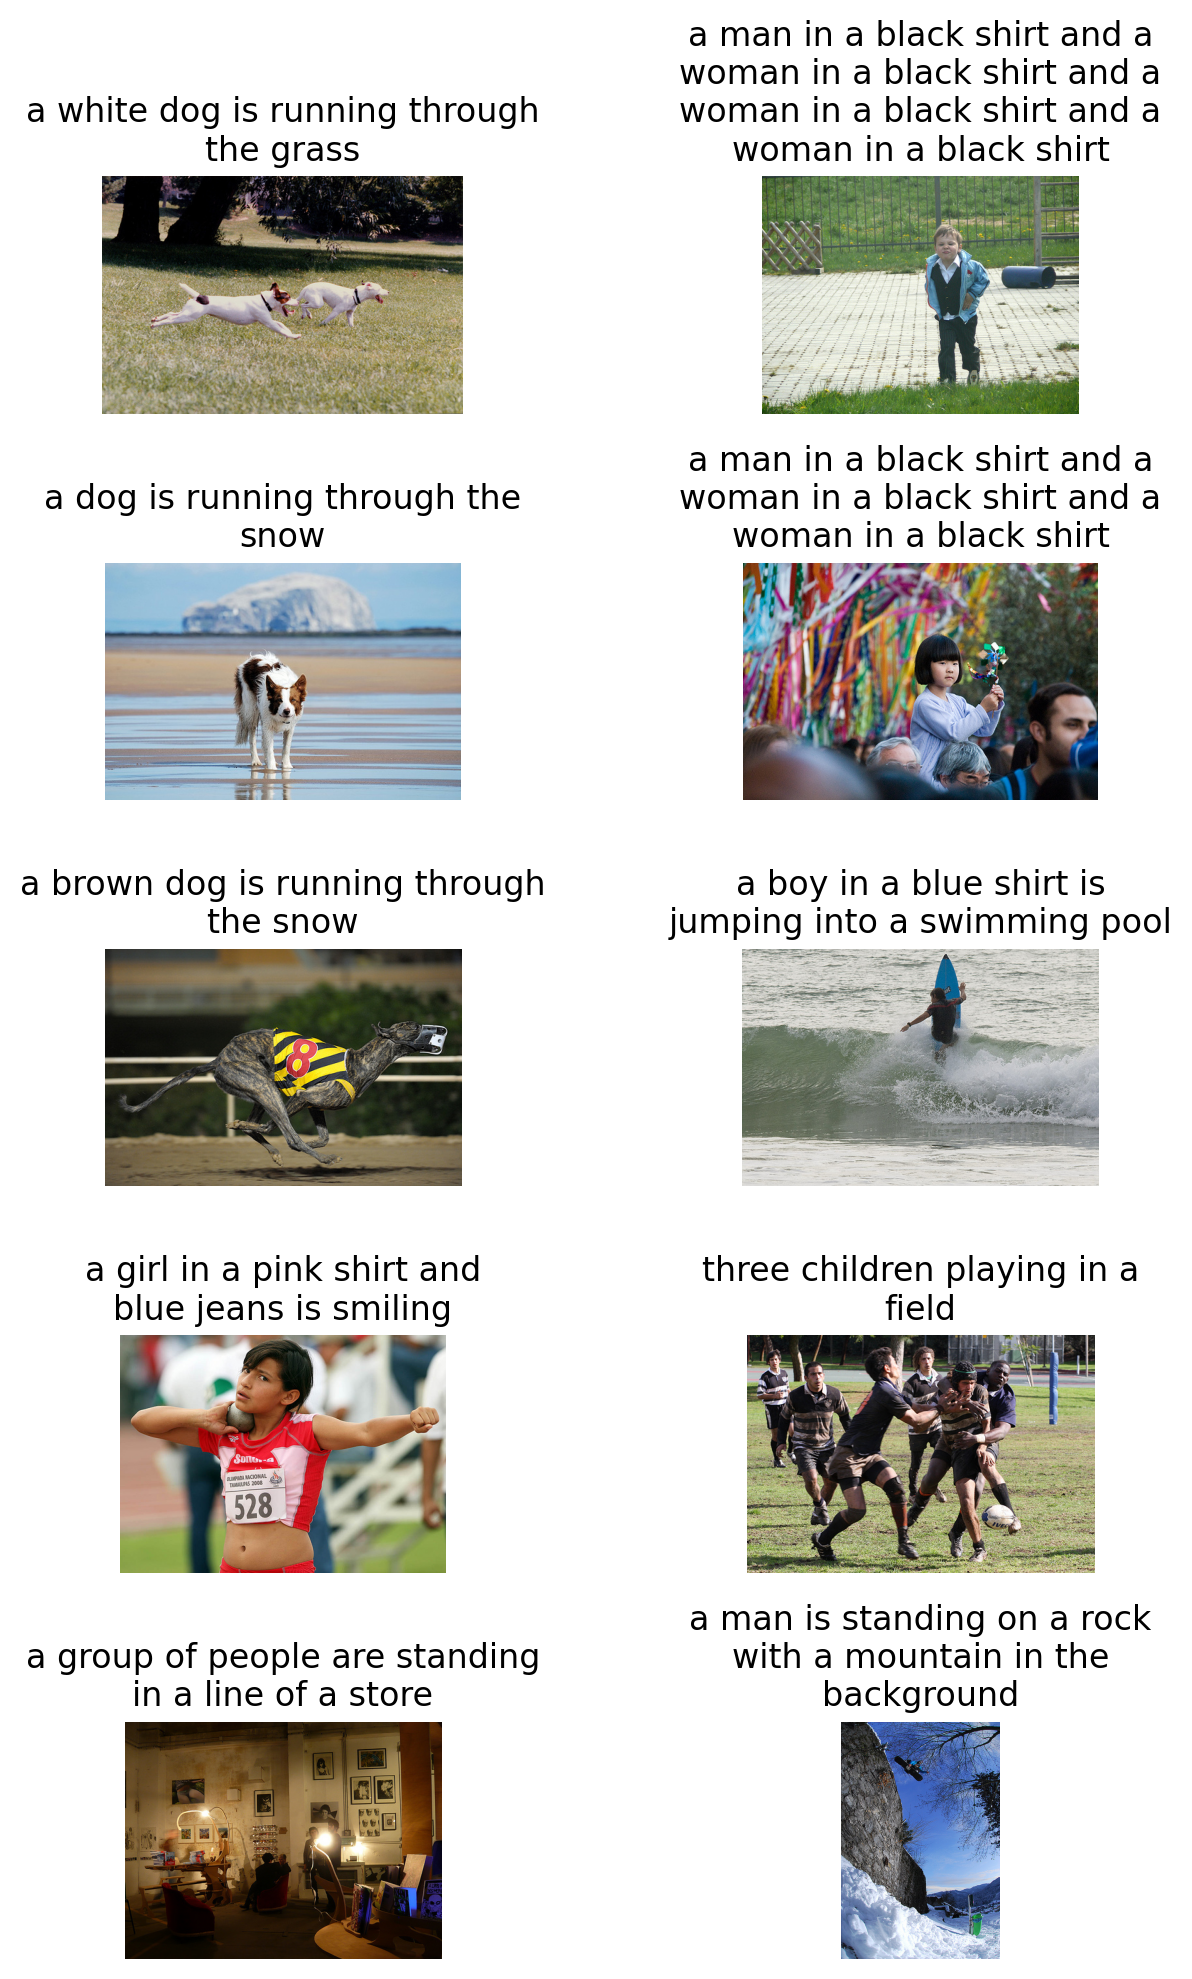

In [93]:
plt.figure(figsize=(7, 10), dpi=200)

nrows, ncols = 5, 2


for i in range(nrows*ncols):
    # Set running seed for reproducible image generation
    np.random.seed(i+10)
    # Get a random index
    random_idx = np.random.randint(0, len(all_image_names))
    # Get the image
    img_full = Image.open(f"./Flicker8k_Dataset/{all_image_names[random_idx]}")
    img_full = img_full.convert("RGB") if img_full.mode != 'RGB' else img_full
    # Get the caption for that image
    label = "\n".join(wrap((" ".join(all_test_caps[random_idx])), 30))
    # Draw a subplot
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(img_full)
    ax.set_title(label)
    plt.axis("off")
    
plt.tight_layout()
plt.savefig("pred2.png")
plt.show()